#ADS-507-01 Group 3 Final Project
#Wild and Wonderful Sales: A Way to Hike Up your Profit
#Ben Earnest, Vannesa Salazar, Renetta Nelson

In [1]:
!pip install mysql-connector-python

In [2]:
#import libraries
import numpy as np
import pandas as pd
import pymysql as mysql
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import requests


In [3]:
#pull the datasets from github

go_1k = pd.DataFrame(pd.read_csv("https://github.com/RenettaNelson/ADS-507---SQL-Data-Pipeline/raw/main/GOSales_data/go_1k.csv"))
go_daily_sales = pd.DataFrame(pd.read_csv("https://github.com/RenettaNelson/ADS-507---SQL-Data-Pipeline/raw/main/GOSales_data/go_daily_sales.csv"))
go_methods = pd.DataFrame(pd.read_csv("https://github.com/RenettaNelson/ADS-507---SQL-Data-Pipeline/raw/main/GOSales_data/go_methods.csv"))
go_products = pd.DataFrame(pd.read_csv("https://github.com/RenettaNelson/ADS-507---SQL-Data-Pipeline/raw/main/GOSales_data/go_products.csv"))
go_retailers = pd.DataFrame(pd.read_csv("https://github.com/RenettaNelson/ADS-507---SQL-Data-Pipeline/raw/main/GOSales_data/go_retailers.csv"))
cpi_monthly = pd.DataFrame(pd.read_csv("https://github.com/RenettaNelson/ADS-507---SQL-Data-Pipeline/raw/main/GOSales_data/1_month_percent_change_in_CPI.csv"))
unemploy_monthly = pd.DataFrame(pd.read_csv("https://github.com/RenettaNelson/ADS-507---SQL-Data-Pipeline/raw/main/GOSales_data/Monthly_unemployment_rate.csv"))


You will need to add your own local server password (need to figure out a cleaner solution)

In [ ]:
# Connect to the sql server
connection = mysql.connect(host='localhost',
                         user='root',
                         password='xxxxx')
                          

# create cursor
cursor = connection.cursor()

#Create Database
cursor.execute("CREATE DATABASE gosales")

You will need to add your own local server password (need to figure out a cleaner solution)

In [7]:
#create engine to add data to sql database "gosales"
db_data = 'mysql+mysqlconnector://' + 'root' + ':' + 'xxxxx' + '@' + 'localhost' + ':3306/' \
       + 'gosales' + '?charset=utf8mb4'
engine = create_engine(db_data)

In [15]:
# Execute the to_sql for writting DF into SQL and add to database
go_1k.to_sql('go_1k', engine, if_exists='append', index=False) 
go_daily_sales.to_sql('go_daily_sales', engine, if_exists='append', index=False) 
go_methods.to_sql('go_methods', engine, if_exists='append', index=False) 
go_products.to_sql('go_products', engine, if_exists='append', index=False) 
go_retailers.to_sql('go_retailers', engine, if_exists='append', index=False) 
cpi_monthly.to_sql('cpi_monthly', engine, if_exists = 'append', index=False)
unemploy_monthly.to_sql('unemploy_monthly', engine, if_exists = 'append', index=False)

You will need to add your own local server password (need to figure out a cleaner solution)

In [5]:
#update connection to use go sales database
connection = mysql.connect(host='localhost',
                         user='root',
                         password='xxxxxx',
                         database='gosales')

We can start queries here to start working the transform part (build the tables we want to use from the database)

In [6]:
#Monthly Sales from January 2015 through August 2016
sales_tot_monthly = pd.DataFrame(pd.read_sql("SELECT Month(Date), \
                                                     year(Date),\
                                                     SUM(`Unit sale price` * Quantity) AS tot_sales \
                                              FROM go_daily_sales \
                                              GROUP BY Month(Date), Year(Date);", 
                                              connection))
sales_tot_monthly

,Month(Date),year(Date),tot_sales
0,1,2015,5794481.28
1,2,2015,6601508.04
2,3,2015,4759314.09
3,4,2015,5420498.10
4,5,2015,5458313.61
5,6,2015,6466946.04
6,7,2015,6198911.55
7,8,2015,6157679.19
8,9,2015,4971723.30
9,10,2015,4822698.75


In [7]:
#Modify month and year to date time, set index to month
sales_tot_monthly['Month(Date)'] = pd.to_datetime(sales_tot_monthly['Month(Date)'], format='%m').dt.month_name().str.slice(stop=3)
sales_tot_monthly['year(Date)'] = pd.to_datetime(sales_tot_monthly['year(Date)'], format='%Y').dt.year
sales_tot_monthly = sales_tot_monthly.set_index('Month(Date)')
sales_tot_monthly


,year(Date),tot_sales
Month(Date),,
Jan,2015,5794481.28
Feb,2015,6601508.04
Mar,2015,4759314.09
Apr,2015,5420498.10
May,2015,5458313.61
Jun,2015,6466946.04
Jul,2015,6198911.55
Aug,2015,6157679.19
Sep,2015,4971723.30


In [34]:
unemploy_2015 = pd.DataFrame(pd.read_sql("SELECT DISTINCT *\
                                     FROM unemploy_monthly\
                                     HAVING Year = 2015;", connection))

unemploy_2015 = unemploy_2015.T
unemploy_2015['2015 Unemployment Rate'] = unemploy_2015[0]
unemploy_2015 = pd.DataFrame(unemploy_2015['2015 Unemployment Rate'])
unemploy_2015 = unemploy_2015.drop('Year')

unemploy_2015

,2015 Unemployment Rate
Jan,5.7
Feb,5.5
Mar,5.4
Apr,5.4
May,5.6
Jun,5.3
Jul,5.2
Aug,5.1
Sep,5.0
Oct,5.0


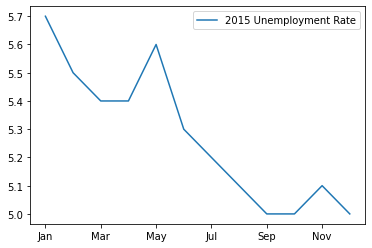

In [36]:
ax = unemploy_2015.plot()

Text(0, 0.5, 'Revenue ($MM)')

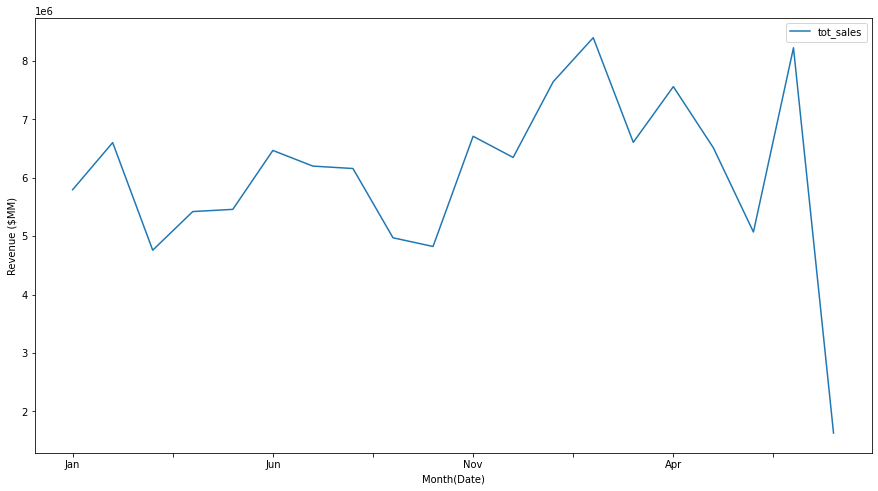

In [20]:
#Plot total monthly sales
ax = sales_tot_monthly.plot(y='tot_sales', figsize= (15,8))
ax.set_ylabel('Revenue ($MM)')

In [9]:
#Total product sales by volume
product_vol = pd.DataFrame(pd.read_sql("SELECT s.Quantity,\
                                               p.Product \
                                        FROM go_daily_sales s \
                                            JOIN go_products p \
                                            ON s.`Product number` = p.`Product number` \
                                        Group by Product Order by Quantity DESC \
                                        LIMIT 20;", 
                                        connection))
product_vol

,Quantity,Product
0,6121,BugShield Extreme
1,4252,Granite Carabiner
2,3992,Single Edge
3,2615,BugShield Natural
4,1913,Sun Shelter 15
5,1762,BugShield Spray
6,1645,Sun Shield
7,1482,Firefly Rechargeable Battery
8,1209,BugShield Lotion
9,1154,TrailChef Kettle


Text(0, 0.5, 'Volume')

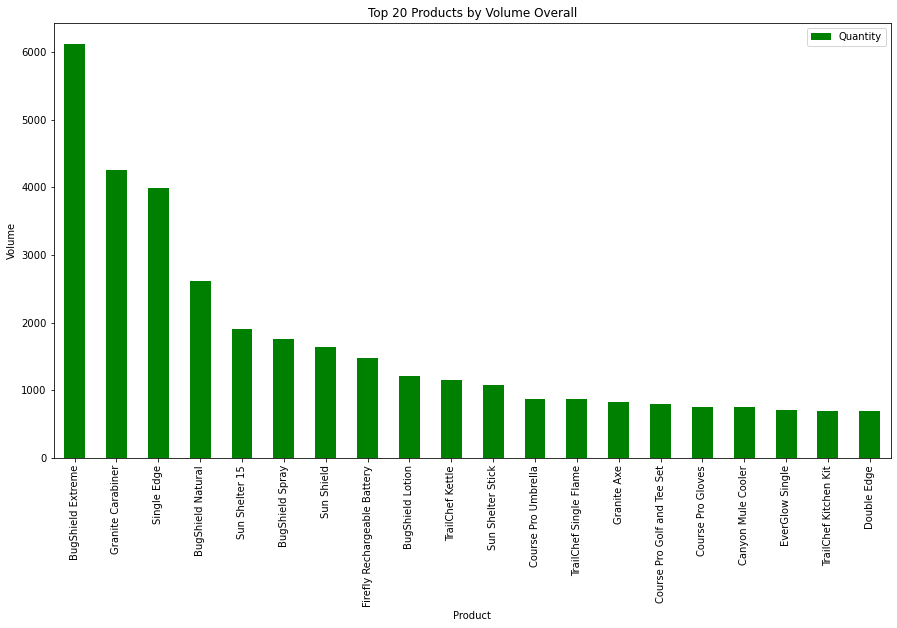

In [10]:
#Plot of product sales by volume (top 20)
ax = product_vol.plot.bar(x='Product', y='Quantity', figsize = (15,8), color='green')
ax.set_title("Top 20 Products by Volume Overall")
ax.set_ylabel('Volume')

In [11]:
product_rev = pd.DataFrame(pd.read_sql("SELECT p.Product,\
                                               SUM(p.`Unit price` * s.Quantity) AS revenue \
                                        FROM go_daily_sales s \
                                            JOIN go_products p \
                                            ON s.`Product number` = p.`Product number` \
                                        Group by Product\
                                        ORDER BY revenue DESC \
                                        LIMIT 20;", 
                                        connection))
product_rev

,Product,revenue
0,Star Lite,33751414.44
1,Canyon Mule Journey Backpack,25513684.56
2,Canyon Mule Weekender Backpack,23314043.61
3,Star Gazer 2,21548957.58
4,Hailstorm Titanium Woods Set,14436926.64
5,Star Gazer 6,13064675.40
6,Canyon Mule Carryall,11209117.50
7,Hailstorm Titanium Irons,10178545.86
8,Lady Hailstorm Steel Irons,9354557.25
9,EverGlow Lamp,9243209.70


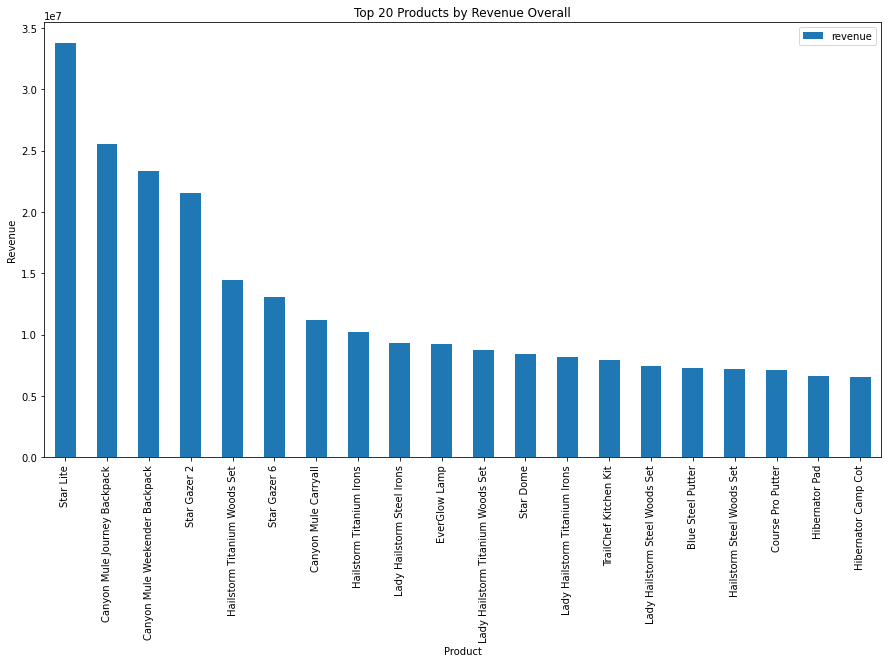

In [12]:
#Plot of product sales by revenue (top 20)
ax = product_rev.plot.bar(x='Product', y=['revenue'], figsize = (15,8))
ax.set_title("Top 20 Products by Revenue Overall")
ax.set_ylabel('Revenue')

plt.show()

In [13]:
#Revenue by product line
product_line_rev = pd.DataFrame(pd.read_sql("SELECT p.`Product line`, \
	                                                SUM(p.`Unit price` * s.Quantity) AS revenue \
                                            FROM go_daily_sales s\
	                                            JOIN go_products p\
                                                ON s.`Product number` = p.`Product number`\
                                            GROUP BY `Product line`\
                                            ORDER BY revenue DESC;",
                                            connection ))

product_line_rev

,Product line,revenue
0,Camping Equipment,2.167693e+08
1,Golf Equipment,1.019446e+08
2,Personal Accessories,3.096770e+07
3,Outdoor Protection,2.246931e+07
4,Mountaineering Equipment,1.932994e+07


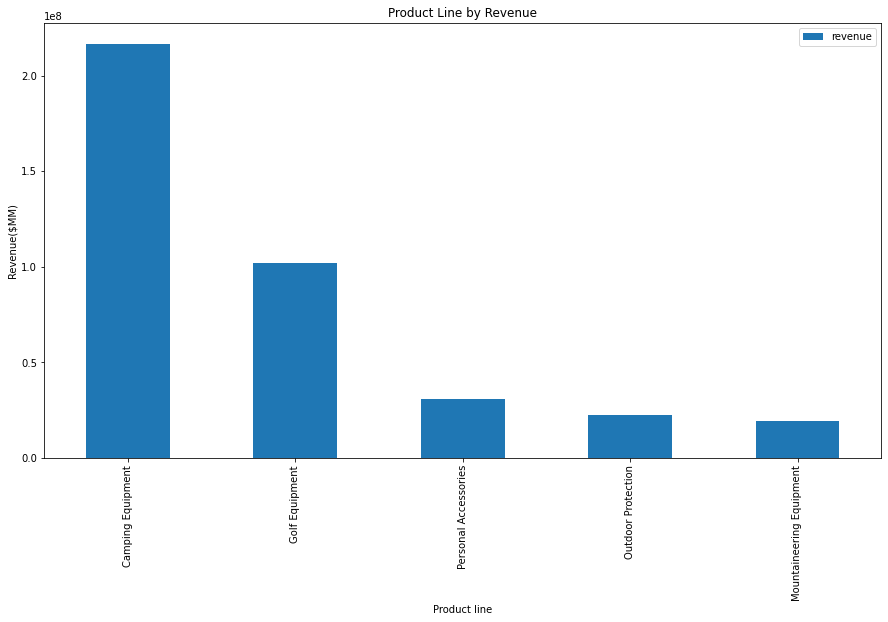

In [14]:
#Plot of product line sales by revenue
ax = product_line_rev.plot.bar(x='Product line', y=['revenue'], figsize = (15,8))
ax.set_title("Product Line by Revenue")
ax.set_ylabel('Revenue($MM)')

plt.show()

In [15]:
#Revenue by product type
product_type_rev = pd.DataFrame(pd.read_sql("SELECT p.`Product type`, \
	                                                SUM(p.`Unit price` * s.Quantity) AS revenue \
                                            FROM go_daily_sales s\
	                                            JOIN go_products p\
                                                ON s.`Product number` = p.`Product number`\
                                            GROUP BY `Product type`\
                                            ORDER BY revenue DESC;",
                                            connection ))

product_type_rev

,Product type,revenue
0,Tents,76800581.82
1,Packs,63924142.59
2,Woods,37791384.66
3,Irons,33968951.19
4,Cooking Gear,29685503.97
5,Lanterns,26629511.13
6,Putters,20104351.20
7,Sleeping Bags,19729537.92
8,Insect Repellents,11959652.16
9,Eyewear,11070838.26


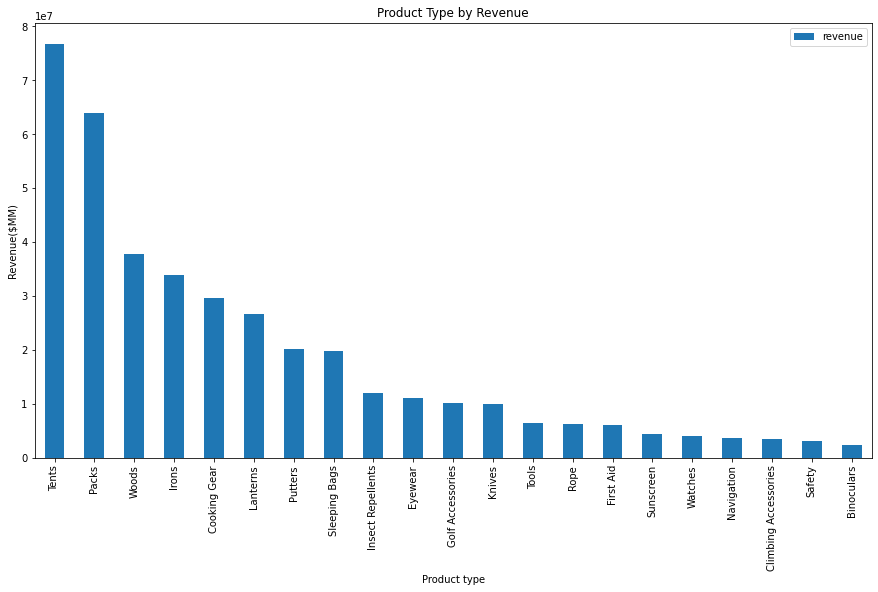

In [16]:
#Plot of product type sales by revenue
ax = product_type_rev.plot.bar(x='Product type', y=['revenue'], figsize = (15,8))
ax.set_title("Product Type by Revenue")
ax.set_ylabel('Revenue($MM)')

plt.show()

In [17]:
#Top 20 retailers by Revenue
retailers_rev = pd.DataFrame(pd.read_sql("SELECT r.`Retailer name`, \
	                                             SUM(s.`Unit price` * s.Quantity) AS revenue\
                                        FROM go_daily_sales s\
	                                        JOIN go_retailers r\
                                            ON s.`Retailer code` = r.`Retailer code`\
                                        GROUP BY `Retailer name`\
                                        ORDER BY revenue DESC\
                                        ;",
                                        connection))

retailers_rev

,Retailer name,revenue
0,The Marketplace,1.015052e+08
1,Consumer Club,9.927307e+07
2,Hartman's,5.441979e+07
3,The Golf Hut,3.101915e+07
4,Edward's Department Store,3.064900e+07
5,Extreme Outdoors,2.855916e+07
6,Connor Department Store,2.606261e+07
7,Falcon Outfitters,8.806980e+06
8,Eagle Eyes,4.720744e+06
9,Buena Vista Eyeware,3.492085e+06


In [18]:
#Top 20 retailers by Revenue
country_rev = pd.DataFrame(pd.read_sql("SELECT r.`Country`, \
	                                             SUM(s.`Unit price` * s.Quantity) AS revenue,\
                                                 r.Country\
                                        FROM go_daily_sales s\
	                                        JOIN go_retailers r\
                                            ON s.`Retailer code` = r.`Retailer code`\
                                        GROUP BY Country\
                                        ORDER BY revenue DESC\
                                        ;",
                                        connection))

country_rev

,Country,revenue,Country
0,United States,3.935245e+08,United States
